<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/Encoder_CNN_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading all the needed things

__Note:__ to do encoder classification. You must have a trained autoencoder first. Here we loaded a model from our google drive.

In [3]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4307, done.
remote: Counting objects: 100% (585/585), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 4307 (delta 220), reused 581 (delta 216), pack-reused 3722
Receiving objects: 100% (4307/4307), 973.48 MiB | 23.69 MiB/s, done.
Resolving deltas: 100% (805/805), done.
Checking out files: 100% (2956/2956), done.
/content/STAT3007_Project


In [4]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3983 sha256=c4b5c441dabad7aaf0f6c1784c0cb0e4fafbf82a019cb4fcb89423e7774f2ef3
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [5]:
import librosa
from librosa import display
import colorednoise as cn
import torch
import numpy as np
from IPython.display import Audio
import glob
from pre_process import *
from data_loading import *
import os
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor

import scipy
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np

# load our own python files
from pre_process import *
from data_loading import *
from Models import *
from Model_Functions import *

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount= True)

Mounted at /content/drive


## load the noisy stratified spectrogram data

In [6]:
# here, the first number means the data was split for once, and it belonged to the that split e.g. noisy_6 contains data split into the 60% once.
# two numbers mean that data was split for twice, it belonged to the first split and the second split e.g. noisy_4_8 contains data split into 40% first, and 80% for second split.

# the first split of noisy data is for autoencoder training, then second split on the first test split is for subsequent classification training.

noisy_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_6.npy')
clean_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_6.npy')
targets_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/target_6.npy')


noisy_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4.npy')
clean_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4.npy')
targets_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4.npy')

noisy_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4_8.npy')
noisy_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4_2.npy')
clean_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4_8.npy')
clean_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4_2.npy')
targets_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4_8.npy')
targets_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4_2.npy')



In [7]:
# reshape
noisy_6 = noisy_6.reshape(noisy_6.shape[0],1,noisy_6.shape[1],noisy_6.shape[2])
clean_6 = clean_6.reshape(clean_6.shape[0],1,clean_6.shape[1],clean_6.shape[2])

noisy_4 = noisy_4.reshape(noisy_4.shape[0],1,noisy_4.shape[1],noisy_4.shape[2])
clean_4 = clean_4.reshape(clean_4.shape[0],1,clean_4.shape[1],clean_4.shape[2])

noisy_4_8 = noisy_4_8.reshape(noisy_4_8.shape[0],1,noisy_4_8.shape[1],noisy_4_8.shape[2])
clean_4_8 = clean_4_8.reshape(clean_4_8.shape[0],1,clean_4_8.shape[1],clean_4_8.shape[2])
noisy_4_2 = noisy_4_2.reshape(noisy_4_2.shape[0],1,noisy_4_2.shape[1],noisy_4_2.shape[2])
clean_4_2 = clean_4_2.reshape(clean_4_2.shape[0],1,clean_4_2.shape[1],clean_4_2.shape[2])

In [8]:
# make them into datasets
denoise_train = DatasetWrapper(torch.tensor(noisy_6), torch.tensor(clean_6))
denoise_test = DatasetWrapper(torch.tensor(noisy_4), torch.tensor(clean_4))

## Load saved model

In [9]:
state_save_path = '/content/drive/MyDrive/STAT3007_project/denoised_saved_model'
#torch.save(net.state_dict(), state_save_path)
model = torch.load(state_save_path)

In [10]:
model

Autoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 2), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
      (4): Conv2d(16, 16, kernel_size=(4, 2), stride=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(16, 16, kernel_size=(4, 2), stride=(1, 1))
      (8): ReLU()
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): ConvTranspose2d(16, 16, kernel_size=(4, 2), stride=(1, 1))
      (1): ReLU()
      (2): Upsample(size=(59, 30), mode=nearest)
      (3): ConvTranspose2d(16, 16, kernel_size=(4, 2), stride=(1, 1))
      (4): ReLU()
      (5): Upsample(size=(125, 62), mode=nearest)
      (6): ConvTranspose2d(16, 1, kernel_size=(4, 2), stride=(1, 1))
    )
  )
)

In [11]:
model.encoder

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(4, 2), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 16, kernel_size=(4, 2), stride=(1, 1))
    (8): ReLU()
  )
)

In [12]:
encoder = model.encoder

# construct compressed feature set
X_train_feature = encoder(torch.tensor(noisy_4_8)).detach()
X_test_feature = encoder(torch.tensor(noisy_4_2)).detach()

y_train = torch.tensor(targets_4_8)
y_test = torch.tensor(targets_4_2)

# made into datasets
data_train = DatasetWrapper(X_train_feature,y_train)
data_test = DatasetWrapper(X_test_feature,y_test)

# CNN model

## Train/test

In [13]:
def train_model(data_train, 
                data_test, 
                net, loss, 
                nepoch , 
                lr = 0.01, 
                batch_size = -1, 
                momentum = 0,
                use_cuda = False, 
                print_output = True, 
                optimiser = 'SGD'):

  # setting up arrays for recording
  test_acc = []
  avg_acc = []

  test_loss = []
  avg_loss = []
  
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  if optimiser == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
  else:
    optimizer = optim.Adam(net.parameters(), lr = lr, momentum = momentum)
  data_train = data_train.change_type(dtype)
  data_test = data_test.change_type(dtype)

  X_test,y_test = data_test.get_data()

  y_test = y_test.type(torch.LongTensor)
  if device != None:
    y_test = y_test.type(torch.cuda.LongTensor)

  data_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)

  for epoch in range(nepoch):
    batch_acc = []
    batch_loss = []
    for X_batch, y_batch in data_loader:
      

      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

      optimizer.zero_grad()


      pred = net(X_batch)
      Rn = loss(pred, y_batch)
      accur = accuracy(pred,y_batch)

      batch_acc.append(accur)
      batch_loss.append(Rn.to(torch.device('cpu')).detach().numpy())

      Rn.backward()
      optimizer.step()


    avg_batch_loss = np.mean(batch_loss)
    avg_batch_acc = np.mean(batch_acc)
    avg_acc.append(avg_batch_acc)
    avg_loss.append(avg_batch_loss)

    pred = net(X_test)
    Rn = loss(pred, y_test)
    accur = accuracy(pred,y_test)
    test_acc.append(accur)
    test_loss.append(Rn.to(torch.device('cpu')).detach().numpy())


    if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
    

  print('final loss:', Rn.item())

  return net, avg_loss, avg_acc, test_loss, test_acc

Hyperparameters:
* random seed = 69
* Optimiser: SGD
* lr: 0.01
* epoch number: 40
* momentum: 0.2

In [14]:
# hyperparameters:
nepoch = 50
lr = 0.01
momentum = 0.2
optimiser = 'SGD'
loss = nn.CrossEntropyLoss()

torch.manual_seed(69)

num_sample, channels, row, column = X_train_feature.shape

CNN = ConvNet(input_shape = (channels, row, column), contain_linear=True)
trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, CNN,loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = optimiser)

final loss: 1.0542384386062622


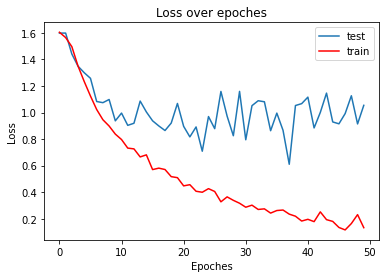

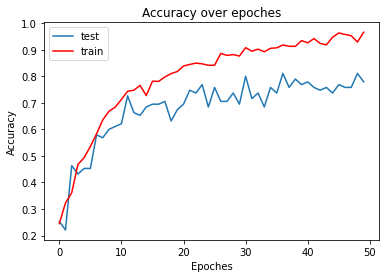

In [15]:
epoches = [i for i in range(nepoch)]

fig = plt.figure()
plt.plot(epoches,test_loss, label = 'test')
plt.plot(epoches,avg_loss, label = 'train', color = 'r')
plt.title('Loss over epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure()
plt.plot(epoches,test_acc, label = 'test')
plt.plot(epoches,avg_acc, label = 'train', color = 'r')
plt.title('Accuracy over epoches')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()

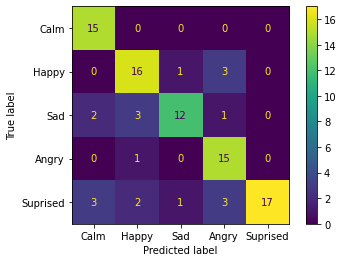

In [17]:
X_test,y_test = data_test.get_data()
trained_net = trained_net.to(torch.device('cpu'))
pred = trained_net(X_test)
y_pred = classification(pred)

labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = metrics.confusion_matrix(y_test.detach().numpy(), y_pred)
thing = metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot(values_format = '.5g')